In [1]:
import scipy.io as sio
import yaml
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from typing import Dict, List
import torchvision.transforms as T

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from torchinfo import summary

from sklearn.metrics import accuracy_score
import seaborn as sns
from tqdm.notebook import tqdm

import utils as u
import RPNetRFextractor as rp

from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
import pickle


from sklearn.model_selection import train_test_split

configuration = yaml.safe_load(open('config.yaml'))
data_path= configuration["data"]
parameters = configuration["parameters"]




# Build data tools

In [2]:
# create data tools : data loader and data set

class HSI_Dataset(Dataset):

    def __init__(self, X, y, transform=None):
        """ X is a FLATTENED HSI volume dataset, y is a 1D FLATTENED tensor with the ground truth"""
        super().__init__()
        if transform is None:
            self.X = torch.tensor(X, dtype=torch.float32)
        else:
            self.X = transform(X) # should be transformed to tensors + normalized
        self.y = torch.tensor(y, dtype=torch.float32) # should be transformed to tensor + normalized
        self.transform = transform

        assert X.shape[0] == len(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, i):
        return self.X[i], self.y[i]


class HSI_AEDataset(Dataset):
    """ Dataset class returning the X values and noise(X)"""
    def __init__(self, X, noise, transform=torch.tensor):
        """ X is a FLATTENED HSI volume dataset, y is a 1D FLATTENED tensor with the ground truth"""
        super().__init__()
        self.X = transform(X) # should be transformed to tensors + normalized
        self.transform = transform
        self.noise = noise

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        if self.noise is None:
            return self.X[i], self.X[i]
        else:
            return self.noise(self.X[i]), self.X[i]



In [3]:
data = u.load_data("KSC")
X, y = data

In [4]:
train_data, test_data, unsup_data = u.data_split(data[1])

# X_train, y_train = X[train_data + unsup_data], y[train_data + unsup_data]
X_train, y_train = X[train_data], y[train_data]
X_test, y_test = X[test_data], y[test_data]

print(X_train.shape, y_train.shape)

(4168, 176) (4168,)


In [5]:

# train_ds = HSI_Dataset(X_train, y_train, transform=in_transform)
# test_ds = HSI_Dataset(X_test, y_test, transform=in_transform)

def scaler(X, vals=None):
    x = torch.tensor(X, dtype=torch.float32)
    m, std = torch.std_mean(x, axis=0)
    if vals is None:
        return (x-m)/std
    else:
        return (x-m)/std, (m, std)
    
def min_max_scaler(X, vals=None):
    x = torch.tensor(X, dtype=torch.float32)
    min, max = torch.min(x, axis=0), torch.max(x, axis=0)
    if vals is None:
        return (x-min)/(max-min)
    else:
        return (x-min)/(max-min), (max,min)

def gaussian_noise(x, m=0, s=0.1):
    x = x+ torch.normal(m*torch.zeros_like(x), std=s*torch.ones_like(x))
    return x

def zero_noise(x, p=10):
    """ randomly sets p coordinates to 0"""
    size = x.shape[0]
    idx = np.random.choice(range(size), size=p, replace=False)
    x[idx]=0.
    return x


train_ds = HSI_Dataset(X_train, y_train)
test_ds = HSI_Dataset(X_test, y_test)


train_dl = DataLoader(train_ds, batch_size=1000, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=1000, shuffle=False)

<Axes: >

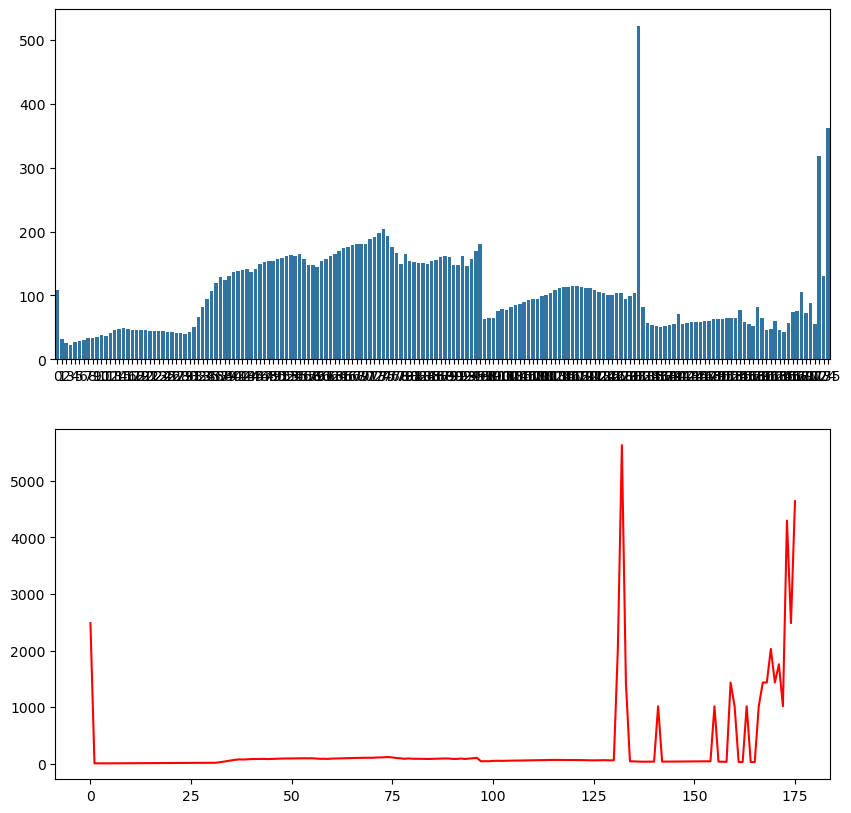

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
sns.barplot(x=np.arange(X_train.mean(axis=0).shape[0]), y=X_train.mean(axis=0), ax=ax[0])

sns.lineplot(x=np.arange(X_train.mean(axis=0).shape[0]), y=X_train.std(axis=0), c='r', ax=ax[1])

/var/folders/c8/ft8h90qs3w15w18mddqpg0h40000gn/T/ipykernel_26963/50868972.py:1: RuntimeWarning: divide by zero encountered in log
  X_log = np.log(X_train+1)
/opt/homebrew/anaconda3/envs/headmind/lib/python3.11/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


<Axes: >

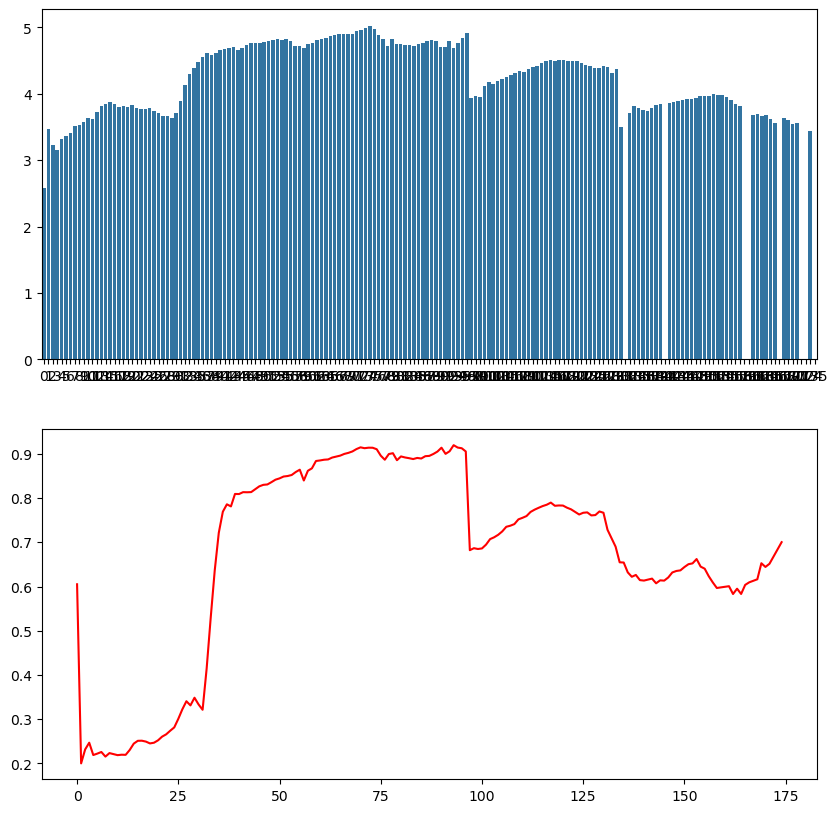

In [7]:
X_log = np.log(X_train+1)

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
sns.barplot(x=np.arange(X_log.mean(axis=0).shape[0]), y=X_log.mean(axis=0), ax=ax[0])

sns.lineplot(x=np.arange(X_log.mean(axis=0).shape[0]), y=X_log.std(axis=0), c='r', ax=ax[1])

# Auto encoder based

# Training

We are going to test a few auto encoders : 

![EncoderImage](EncoderTypes.png)

$J(W,b) = \frac{1}{m} \sum_{i=1}^{m} \frac{1}{2} | r^{(i)} - x^{(i)}|^2 + \frac{\lambda}{2} \sum_{l=1}^{n_l-1} \sum_{i=1}^{s_l} \sum_{j=1}^{s_{l+1}} (W_{ji}^{(l)})^2 + \beta \sum_{k=1}^{m} KL(\rho | \hat{\rho}_k)$

In [8]:
(np.log(512)+ np.log(614) + np.log(176))/np.log(2)/16

1.6075954040004672

## Uncomplete auto encoders

In [9]:
data = u.load_data("KSC")
X, y = data
train_data, test_data, unsup_data = u.data_split(data[1])
X_log = np.log(X/2+1)-np.log(2)

X_train_full, y_train_full = X_log[train_data + unsup_data], y[train_data + unsup_data]
X_train, y_train = X_log[train_data], y[train_data]
X_unsup, y_unsup = X_log[unsup_data], y[unsup_data]
X_test, y_test = X_log[test_data], y[test_data]

print("Full : ", X_train_full.shape, y_train_full.shape)
print("Not Full : ", X_train.shape, y_train.shape)

Full :  (313325, 176) (313325,)
Not Full :  (4168, 176) (4168,)


In [87]:
import ae_architecture as ae


# train_ds = HSI_AEDataset(X_train_full, noise=None, transform=scaler)
train_ds = HSI_AEDataset(X_train, noise=None, transform=scaler)
test_ds = HSI_AEDataset(X_test, noise=None, transform=scaler)
unsup_ds = HSI_AEDataset(X_unsup, noise=None, transform=scaler)

# batch size à 522 pour avoir qqch qui divise la taille du dataset

train_dl = DataLoader(train_ds, batch_size=522, shuffle=True)
unsup_dl = DataLoader(unsup_ds, batch_size=2048, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=1043, shuffle=False)


# CONSTANTS

n_in = X_train.shape[1] # next(iter(train_dl))[0].shape[1]
bottleneck= 14 # because 14 classes

### Question : What is the right architecture, and how many epochs do we need ?
Solution : Test a few diffrent architectures and epochs

In [88]:
ratios = [0.2, 0.4, 0.6, 1.0, 1.5, 2.0, 3.0, 5.0]


def test_different_sae(ratios, lr=0.001, n_in=n_in, bottleneck=bottleneck):

    results = {r: [] for r in ratios}

    for r in tqdm(ratios, desc="Processing Ratios"):
        sae = ae.ShallowAE(n_in, int(n_in*r), bottleneck)
        loss_fn = nn.MSELoss()
        optimizer = torch.optim.Adam(params=sae.parameters(), lr=lr)
        loss_train, loss_test= ae.train_ae(sae, optimizer, loss_fn, train_dl, test_dl, epochs=30, verbose=False)
        results[r]=[loss_train, loss_test]
        torch.save(sae.state_dict(), f"models/sae_{r}.pt")
    epoch_results = {r: (
                     [results[r][0][epoch].mean() for epoch in range(30)],
                     [results[r][1][epoch].mean() for epoch in range(30)]
                     ) 
                     for r in ratios}
    
    with open(f'models/resultats_lr{lr}.pkl', 'wb') as file:
        pickle.dump(epoch_results, file)
    print(f"Dictionary saved to models/results_lr{lr}.pkl")
    
    return epoch_results

In [89]:
def test_shallow_ae(ratio:float, lr:float, n_in:int=n_in, bottleneck:int=14, epochs:int=30):
    sae = ae.ShallowAE(n_in, int(n_in*ratio), bottleneck)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(params=sae.parameters(), lr=lr)
    loss_train, loss_test= ae.train_ae(sae, optimizer, loss_fn, train_dl, test_dl, device="mps", epochs=epochs, verbose=False)
    results = np.array([lt.mean() for lt in loss_train]), np.array([lt.mean() for lt in loss_test])
    # torch.save(sae.state_dict(), f"models/sae_{r}_{lr}_{epochs}.pt")
    return results #, sae

def plot_ae(ratio:float, lr:float, n_in:int=n_in, bottleneck:int=14, epochs:int=30):

    #auto encoder build
    sae = ae.ShallowAE(n_in, int(n_in*ratio), bottleneck)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(params=sae.parameters(), lr=lr)

    # Auto encoder training
    loss_train, loss_test= ae.train_ae(sae, optimizer, loss_fn, train_dl, test_dl, epochs=epochs, verbose=False)
    results = np.array([lt.mean() for lt in loss_train]), np.array([lt.mean() for lt in loss_test])

    #figure plotting
    fig, ax = plt.subplots(2,1, figsize=(6,12))
    ax[0].plot(range(epochs), results[0], c='orange', label='Train')
    ax[0].plot(range(epochs), results[1], c='b', label='Test')

    ax[1].plot(range(epochs), np.log(results[0]), c='orange', label='logTrain')
    ax[1].plot(range(epochs), np.log(results[1]), c='b', label='logTest')
    plt.legend()
    plt.savefig(f"figures/ae{ratio}_{lr}_{n_in}_{bottleneck}_{epochs}.png")

    return results

Epoch 1 :
	LOSSES : 0.20569187682121992 - 0.06711795181035995
Epoch 2 :
	LOSSES : 0.039003838086500764 - 0.031555842608213425
Epoch 3 :
	LOSSES : 0.026879375567659736 - 0.021869443356990814
Epoch 4 :
	LOSSES : 0.019243383314460516 - 0.01632135920226574
Epoch 5 :
	LOSSES : 0.015394043526612222 - 0.01383888442069292
Epoch 6 :
	LOSSES : 0.013238085201010108 - 0.011986143887043
Epoch 7 :
	LOSSES : 0.011829721392132342 - 0.011393178254365921
Epoch 8 :
	LOSSES : 0.011472932994365692 - 0.011141973547637463
Epoch 9 :
	LOSSES : 0.011288372566923499 - 0.010957431979477406
Epoch 10 :
	LOSSES : 0.011107086669653654 - 0.010790983214974403
Epoch 11 :
	LOSSES : 0.010949126211926341 - 0.010631242766976357
Epoch 12 :
	LOSSES : 0.010779527830891311 - 0.010466678068041801
Epoch 13 :
	LOSSES : 0.01060298434458673 - 0.010310308076441288
Epoch 14 :
	LOSSES : 0.01047043432481587 - 0.01015700027346611
Epoch 15 :
	LOSSES : 0.010277430876158178 - 0.009928401559591293
Epoch 16 :
	LOSSES : 0.010095995385199785 - 

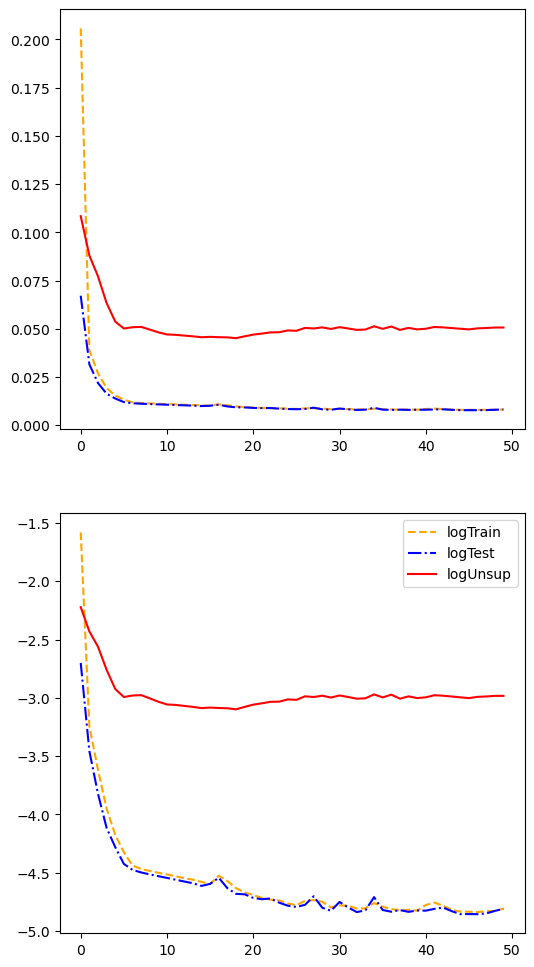

In [90]:
#auto encoder build
EPOCHS=50
sae = ae.ShallowAE(n_in, int(2*n_in), bottleneck)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=sae.parameters(), lr=0.005)

# Auto encoder training
loss_train, loss_test, loss_unsup= ae.train_ae(sae, optimizer, loss_fn, train_dl, test_dl, EPOCHS, unsup_dl=unsup_dl, device="mps", verbose=True)
results = np.array(loss_train), np.array(loss_test), np.array(loss_unsup)

#figure plotting
fig, ax = plt.subplots(2,1, figsize=(6,12))
ax[0].plot(range(EPOCHS), results[0], c='orange', label='Train', linestyle='--')
ax[0].plot(range(EPOCHS), results[1], c='b', label='Test', linestyle='-.')
ax[0].plot(range(EPOCHS), results[2], c='r', label='Unsup')

ax[1].plot(range(EPOCHS), np.log(results[0]), c='orange', label='logTrain', linestyle='--')
ax[1].plot(range(EPOCHS), np.log(results[1]), c='b', label='logTest', linestyle='-.')
ax[1].plot(range(EPOCHS), np.log(results[2]), c='r', label='logUnsup')
plt.legend()

# Test d'efficacité sur classif:

In [91]:
torch.save(sae.state_dict(), f"models/sae_{2.}_{0.005}_{50}.pt")

In [104]:
def encode_x(x, autoencoder, preprocessing=None, device="cpu"):
    """ Encodes the data using the autoencoder"""
    autoencoder.to(device).eval()
    x = torch.tensor(x, device=device, dtype=torch.float32)
    if preprocessing is not None:
        x = preprocessing(x)
    x_encoded = autoencoder.encode(x)
    return x_encoded


In [122]:
latent_x_unsup = encode_x(X_unsup, sae, preprocessing=scaler, device="mps")
latent_x_train = encode_x(X_train, sae, preprocessing=scaler, device="mps")
latent_x_test = encode_x(X_test, sae, preprocessing=scaler, device="mps")

/var/folders/c8/ft8h90qs3w15w18mddqpg0h40000gn/T/ipykernel_26963/34164461.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(X, dtype=torch.float32)


In [134]:
latent_x_unsup_np = latent_x_unsup.to("cpu").detach().numpy()
latent_x_train_np = latent_x_train.to("cpu").detach().numpy()
latent_x_test_np = latent_x_test.to("cpu").detach().numpy()

In [140]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
# import random forest : 
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score


# C, kernel, degree, gamma.

rf = RandomForestClassifier(n_estimators=100, max_depth=13, random_state=42)
svc =  SVC(C=100, kernel='rbf', degree=3, gamma=2)

svc.fit(latent_x_train_np, y_train)
rf.fit(latent_x_train_np, y_train)

print(accuracy_score(y_test, svc.predict(latent_x_test_np)))
print(accuracy_score(y_test, rf.predict(latent_x_test_np)))
# print(accuracy_score(y_test, ))

0.4947267497603068
0.4793863854266539


# SQRT encoders : 

In [141]:
X_sqrt = np.sqrt(X/2+1)

X_train_full, y_train_full = X_sqrt[train_data + unsup_data], y[train_data + unsup_data]
X_train2, y_train = X_sqrt[train_data], y[train_data]
X_unsup2, y_unsup = X_sqrt[unsup_data], y[unsup_data]
X_test2, y_test = X_sqrt[test_data], y[test_data]

# print("Full : ", X_train_full.shape, y_train_full.shape)
# print("Not Full : ", X_train2.shape, y_train.shape)

# train_ds = HSI_AEDataset(X_train_full, noise=None, transform=scaler)
train_ds2 = HSI_AEDataset(X_train2, noise=None, transform=scaler)
test_ds2 = HSI_AEDataset(X_test2, noise=None, transform=scaler)
unsup_ds2 = HSI_AEDataset(X_unsup2, noise=None, transform=scaler)

# batch size à 522 pour avoir qqch qui divise la taille du dataset

train_dl2 = DataLoader(train_ds2, batch_size=522, shuffle=True)
unsup_dl2 = DataLoader(unsup_ds2, batch_size=2048, shuffle=True)
test_dl2 = DataLoader(test_ds2, batch_size=1043, shuffle=False)


# CONSTANTS

n_in = X_train2.shape[1] # next(iter(train_dl))[0].shape[1]
bottleneck= 14 # because 14 classes

Epoch 1 :
	LOSSES : 0.4657866731286049 - 0.3232041597366333
Epoch 2 :
	LOSSES : 0.28512720949947834 - 0.2593648433685303
Epoch 3 :
	LOSSES : 0.2328360676765442 - 0.21937057375907898
Epoch 4 :
	LOSSES : 0.17311768140643835 - 0.16724152863025665
Epoch 5 :
	LOSSES : 0.14156311377882957 - 0.14239847660064697
Epoch 6 :
	LOSSES : 0.11899473611265421 - 0.12693288922309875
Epoch 7 :
	LOSSES : 0.10409979848191142 - 0.12299539148807526
Epoch 8 :
	LOSSES : 0.09186435909941792 - 0.10750675201416016
Epoch 9 :
	LOSSES : 0.07920327223837376 - 0.10035766661167145
Epoch 10 :
	LOSSES : 0.06737481954041868 - 0.09087329357862473
Epoch 11 :
	LOSSES : 0.05455116170924157 - 0.0865565687417984
Epoch 12 :
	LOSSES : 0.04666066518984735 - 0.08181528747081757
Epoch 13 :
	LOSSES : 0.042926494614221156 - 0.08472628146409988
Epoch 14 :
	LOSSES : 0.039871263375971466 - 0.07920143008232117
Epoch 15 :
	LOSSES : 0.03778561652870849 - 0.08045359700918198
Epoch 16 :
	LOSSES : 0.03474006161559373 - 0.07726212590932846
Epoc

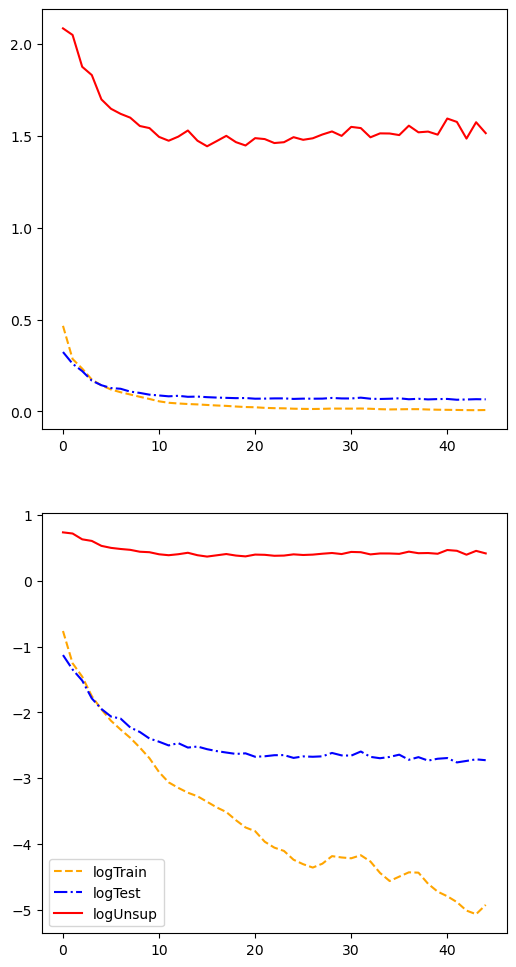

In [144]:
#auto encoder build
EPOCHS=45
r=2
sae_sqrt = ae.ShallowAE(n_in, int(r*n_in), bottleneck)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=sae_sqrt.parameters(), lr=0.003)

# Auto encoder training
loss_train, loss_test, loss_unsup= ae.train_ae(sae_sqrt, optimizer, loss_fn, train_dl2, test_dl2, EPOCHS, unsup_dl=unsup_dl2, device="mps", verbose=True)
results = np.array(loss_train), np.array(loss_test), np.array(loss_unsup)

#figure plotting
fig, ax = plt.subplots(2,1, figsize=(6,12))
ax[0].plot(range(EPOCHS), results[0], c='orange', label='Train', linestyle='--')
ax[0].plot(range(EPOCHS), results[1], c='b', label='Test', linestyle='-.')
ax[0].plot(range(EPOCHS), results[2], c='r', label='Unsup')

ax[1].plot(range(EPOCHS), np.log(results[0]), c='orange', label='logTrain', linestyle='--')
ax[1].plot(range(EPOCHS), np.log(results[1]), c='b', label='logTest', linestyle='-.')
ax[1].plot(range(EPOCHS), np.log(results[2]), c='r', label='logUnsup')
plt.legend()

In [145]:
#auto encoder build
def draft_plot_ae(EPOCHS, r, lr):
    sae_sqrt = ae.ShallowAE(n_in, int(r*n_in), bottleneck)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(params=sae_sqrt.parameters(), lr=lr)

    # Auto encoder training
    loss_train, loss_test, loss_unsup= ae.train_ae(sae_sqrt, optimizer, loss_fn, train_dl2, test_dl2, EPOCHS, unsup_dl=unsup_dl2, device="mps", verbose=False£)
    results = np.array(loss_train), np.array(loss_test), np.array(loss_unsup)

    #figure plotting
    fig, ax = plt.subplots(2,1, figsize=(6,12))
    ax[0].plot(range(EPOCHS), results[0], c='orange', label='Train', linestyle='--')
    ax[0].plot(range(EPOCHS), results[1], c='b', label='Test', linestyle='-.')
    ax[0].plot(range(EPOCHS), results[2], c='r', label='Unsup')

    ax[1].plot(range(EPOCHS), np.log(results[0]), c='orange', label='logTrain', linestyle='--')
    ax[1].plot(range(EPOCHS), np.log(results[1]), c='b', label='logTest', linestyle='-.')
    ax[1].plot(range(EPOCHS), np.log(results[2]), c='r', label='logUnsup')
    plt.legend()

Epoch 1 :
	LOSSES : 0.4829628951847553 - 0.3557070791721344
Epoch 2 :
	LOSSES : 0.2887467760592699 - 0.2676391303539276
Epoch 3 :
	LOSSES : 0.2525055054575205 - 0.24292965233325958
Epoch 4 :
	LOSSES : 0.2078408282250166 - 0.20814149081707
Epoch 5 :
	LOSSES : 0.1819403236731887 - 0.19078782200813293
Epoch 6 :
	LOSSES : 0.16100081522017717 - 0.16616271436214447
Epoch 7 :
	LOSSES : 0.14289639238268137 - 0.15022817254066467
Epoch 8 :
	LOSSES : 0.12700455682352185 - 0.13709118962287903
Epoch 9 :
	LOSSES : 0.11323309782892466 - 0.1244807168841362
Epoch 10 :
	LOSSES : 0.09706121985800564 - 0.1081058457493782
Epoch 11 :
	LOSSES : 0.08819521253462881 - 0.10459627956151962
Epoch 12 :
	LOSSES : 0.08185595227405429 - 0.09907065331935883
Epoch 13 :
	LOSSES : 0.0777925094589591 - 0.1043793261051178
Epoch 14 :
	LOSSES : 0.07497301325201988 - 0.09405466169118881
Epoch 15 :
	LOSSES : 0.07306519482517615 - 0.0969654768705368
Epoch 16 :
	LOSSES : 0.07162606157362461 - 0.09510443359613419
Epoch 17 :
	LOSS

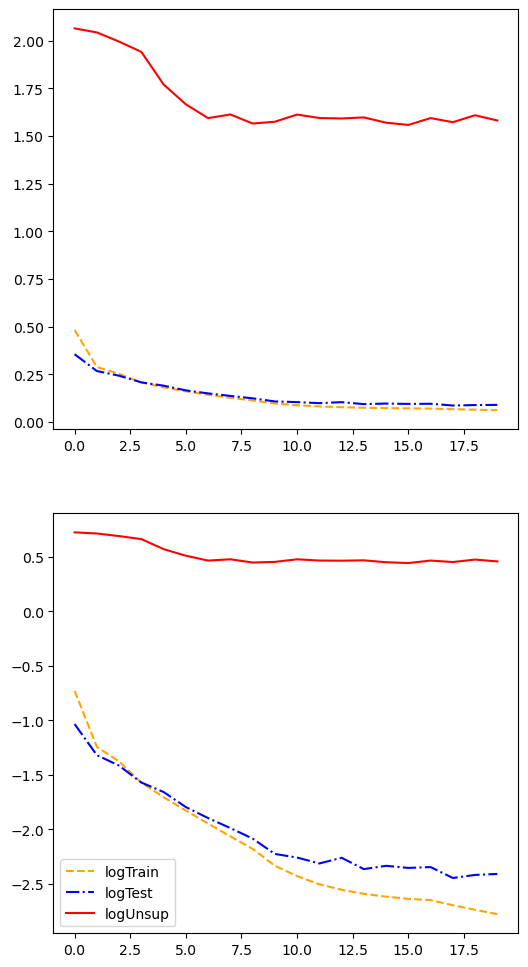

In [149]:
draft_plot_ae(EPOCHS=20, r=2, lr=0.0035)

Epoch 1 :
	LOSSES : 0.4162886831909418 - 0.3076474964618683
Epoch 2 :
	LOSSES : 0.26578107476234436 - 0.2568987011909485
Epoch 3 :
	LOSSES : 0.21491358056664467 - 0.20720751583576202
Epoch 4 :
	LOSSES : 0.17731511313468218 - 0.1772739142179489
Epoch 5 :
	LOSSES : 0.1460560467094183 - 0.15377461910247803
Epoch 6 :
	LOSSES : 0.11575556825846434 - 0.12983760237693787
Epoch 7 :
	LOSSES : 0.09376954520121217 - 0.1244986429810524
Epoch 8 :
	LOSSES : 0.08617402706295252 - 0.11532862484455109
Epoch 9 :
	LOSSES : 0.08228477742522955 - 0.11683104932308197
Epoch 10 :
	LOSSES : 0.0759608477819711 - 0.10937916487455368
Epoch 11 :
	LOSSES : 0.07143768365494907 - 0.10311423242092133
Epoch 12 :
	LOSSES : 0.06529969815164804 - 0.10253610461950302
Epoch 13 :
	LOSSES : 0.060770977404899895 - 0.09847136586904526
Epoch 14 :
	LOSSES : 0.05199705727864057 - 0.08965934067964554
Epoch 15 :
	LOSSES : 0.04582099843537435 - 0.08656524121761322
Epoch 16 :
	LOSSES : 0.042865818075370044 - 0.08399497717618942
Epoch 

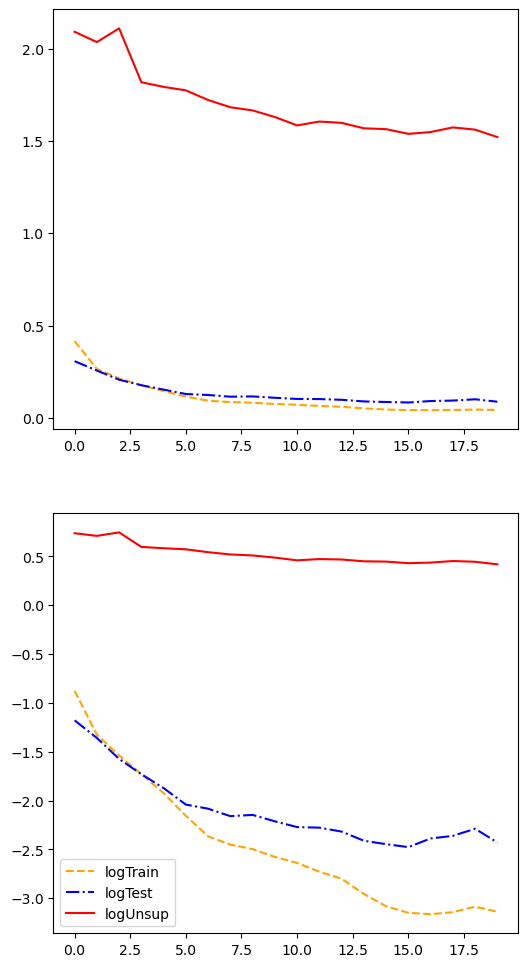

In [150]:
draft_plot_ae(EPOCHS=20, r=2.5, lr=0.003)

Epoch 1 :
	LOSSES : 0.43824748508632183 - 0.28864362835884094
Epoch 2 :
	LOSSES : 0.2710537388920784 - 0.25556284189224243
Epoch 3 :
	LOSSES : 0.23145420476794243 - 0.2186887562274933
Epoch 4 :
	LOSSES : 0.18315116502344608 - 0.18445736169815063
Epoch 5 :
	LOSSES : 0.1543478723615408 - 0.15414270758628845
Epoch 6 :
	LOSSES : 0.11667197337374091 - 0.1363210529088974
Epoch 7 :
	LOSSES : 0.09192978031933308 - 0.11145690828561783
Epoch 8 :
	LOSSES : 0.07104180613532662 - 0.09891194850206375
Epoch 9 :
	LOSSES : 0.060281872283667326 - 0.09148524701595306
Epoch 10 :
	LOSSES : 0.05200989521108568 - 0.08833996951580048
Epoch 11 :
	LOSSES : 0.045072007924318314 - 0.07713182270526886
Epoch 12 :
	LOSSES : 0.03923690039664507 - 0.07558009028434753
Epoch 13 :
	LOSSES : 0.03587940940633416 - 0.07687807083129883
Epoch 14 :
	LOSSES : 0.030642152240034193 - 0.07421115785837173
Epoch 15 :
	LOSSES : 0.028568372363224626 - 0.07181679457426071
Epoch 16 :
	LOSSES : 0.0261551103903912 - 0.07204364985227585
Ep

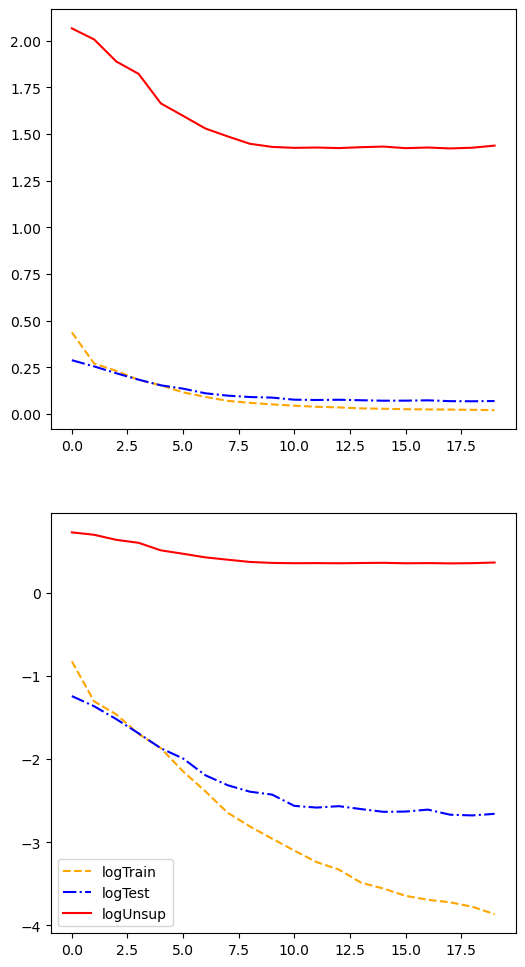

In [151]:
draft_plot_ae(EPOCHS=20, r=1.5, lr=0.003)

Epoch 1 :
	LOSSES : 0.4742804765701294 - 0.2776716351509094
Epoch 2 :
	LOSSES : 0.27377110347151756 - 0.2648613750934601
Epoch 3 :
	LOSSES : 0.24016091413795948 - 0.23579145967960358
Epoch 4 :
	LOSSES : 0.2008812464773655 - 0.19235166907310486
Epoch 5 :
	LOSSES : 0.15906251408159733 - 0.15520110726356506
Epoch 6 :
	LOSSES : 0.11341395042836666 - 0.12656867504119873
Epoch 7 :
	LOSSES : 0.08281283732503653 - 0.11142215877771378
Epoch 8 :
	LOSSES : 0.06775294616818428 - 0.09652524441480637
Epoch 9 :
	LOSSES : 0.057761008269153535 - 0.08929203450679779
Epoch 10 :
	LOSSES : 0.04819639283232391 - 0.08370113372802734
Epoch 11 :
	LOSSES : 0.04318718163995072 - 0.08296844363212585
Epoch 12 :
	LOSSES : 0.0394558259868063 - 0.07765498757362366
Epoch 13 :
	LOSSES : 0.034554712707176805 - 0.07589847594499588
Epoch 14 :
	LOSSES : 0.031827280297875404 - 0.0757375955581665
Epoch 15 :
	LOSSES : 0.026955219451338053 - 0.07342706620693207
Epoch 16 :
	LOSSES : 0.024304373480845243 - 0.07193811982870102
Ep

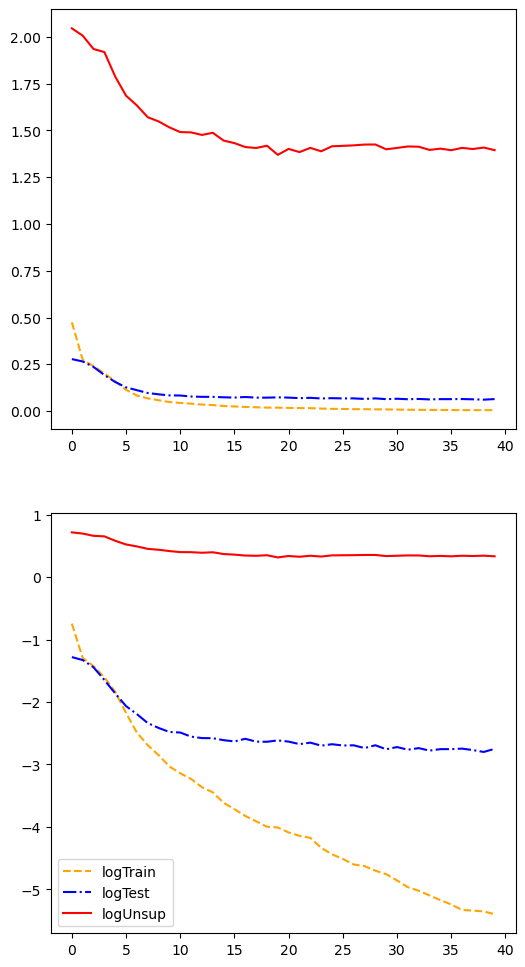

In [153]:
draft_plot_ae(EPOCHS=40, r=2, lr=0.002)

Epoch 1 :
	LOSSES : 0.48189229518175125 - 0.28096839785575867
Epoch 2 :
	LOSSES : 0.27965315245091915 - 0.26680874824523926
Epoch 3 :
	LOSSES : 0.24046204052865505 - 0.2299078106880188
Epoch 4 :
	LOSSES : 0.2004708582535386 - 0.1995544135570526
Epoch 5 :
	LOSSES : 0.17121244687587023 - 0.1707577258348465
Epoch 6 :
	LOSSES : 0.1425704574212432 - 0.14469851553440094
Epoch 7 :
	LOSSES : 0.1187819391489029 - 0.12782613933086395
Epoch 8 :
	LOSSES : 0.10295321932062507 - 0.11586691439151764
Epoch 9 :
	LOSSES : 0.09201408561784774 - 0.10788101702928543
Epoch 10 :
	LOSSES : 0.0798141851555556 - 0.09679683297872543
Epoch 11 :
	LOSSES : 0.056034778943285346 - 0.08999768644571304
Epoch 12 :
	LOSSES : 0.04688029165845364 - 0.08691670000553131
Epoch 13 :
	LOSSES : 0.041630858555436134 - 0.0846036747097969
Epoch 14 :
	LOSSES : 0.03723547572735697 - 0.08609812706708908
Epoch 15 :
	LOSSES : 0.03673683118540794 - 0.07995891571044922
Epoch 16 :
	LOSSES : 0.033402130007743835 - 0.08516433835029602
Epoch 

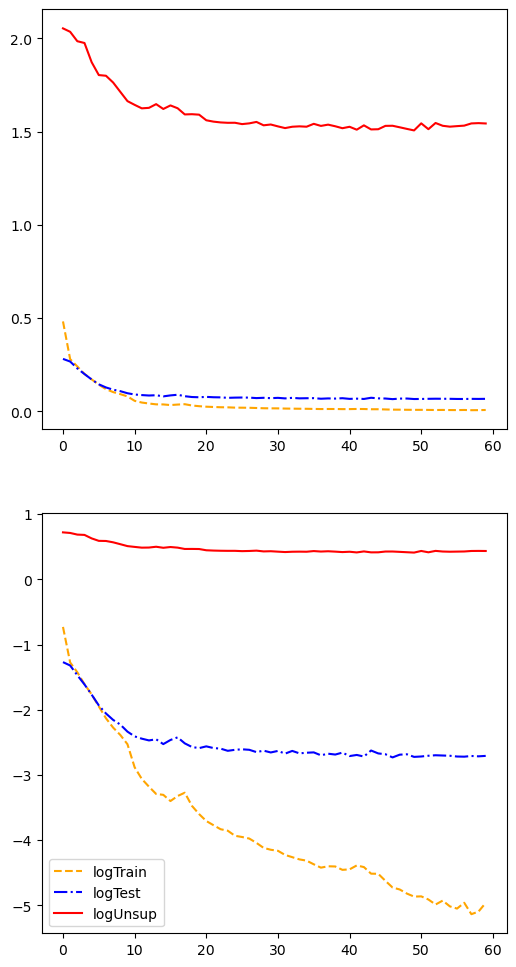

In [154]:
draft_plot_ae(EPOCHS=60, r=2, lr=0.002)

Epoch 1 :
	LOSSES : 0.5053154416382313 - 0.26999184489250183
Epoch 2 :
	LOSSES : 0.2780314851552248 - 0.2772374749183655
Epoch 3 :
	LOSSES : 0.23563871905207634 - 0.22337105870246887
Epoch 4 :
	LOSSES : 0.190559939481318 - 0.1831563264131546
Epoch 5 :
	LOSSES : 0.14433452021330595 - 0.14282916486263275
Epoch 6 :
	LOSSES : 0.10129050351679325 - 0.11933569610118866
Epoch 7 :
	LOSSES : 0.07901304727420211 - 0.1009223684668541
Epoch 8 :
	LOSSES : 0.06454141857102513 - 0.09140311181545258
Epoch 9 :
	LOSSES : 0.0541524956934154 - 0.08278554677963257
Epoch 10 :
	LOSSES : 0.047821067622862756 - 0.08011497557163239
Epoch 11 :
	LOSSES : 0.04373521567322314 - 0.07993164658546448
Epoch 12 :
	LOSSES : 0.04007529467344284 - 0.07639870047569275
Epoch 13 :
	LOSSES : 0.0365027382504195 - 0.07370148599147797
Epoch 14 :
	LOSSES : 0.03354384144768119 - 0.07435972988605499
Epoch 15 :
	LOSSES : 0.029580685892142355 - 0.07107154279947281
Epoch 16 :
	LOSSES : 0.02675718310638331 - 0.07198493927717209
Epoch 17

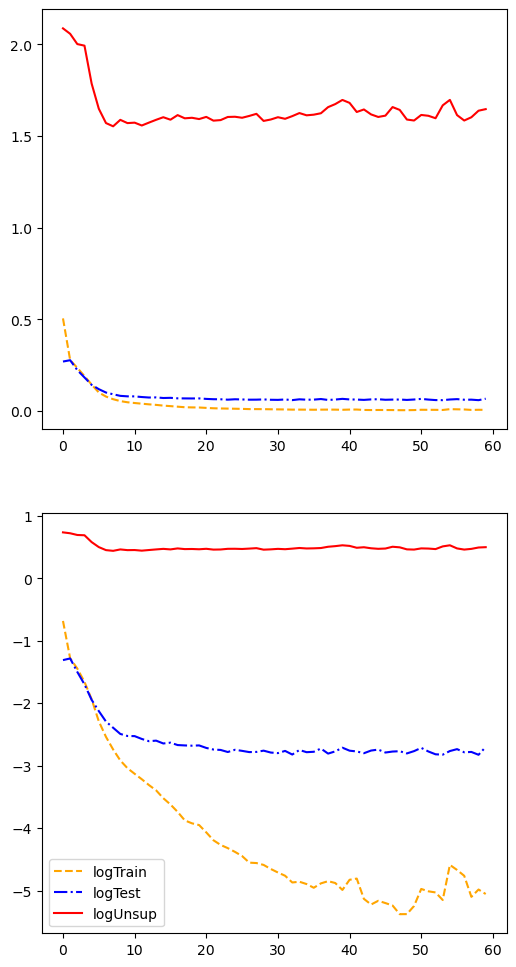

In [155]:
draft_plot_ae(EPOCHS=60, r=2, lr=0.002)